# Gradient descent algorithm for Scenario 2


In this part, we implement an gradient descent algorithm to optimization the objective loss function in Scenario 2:


$$\min F := \min \frac{1}{2(n-i)} \sum_{i=1000}^n (fbpredic(i) + a*tby(i) +b*ffr(i) + c*fta(i) - asp(i))^2$$

Gradient descent: 

$$ \beta_k = \beta_{k-1} + \delta* \nabla F, $$
where $\delta$ control how far does each iteration go.


### Detailed plan

First, split the data as train and test with 80% and 20% respectively. For the training part, we need prophet() predicted price, there are a couple of issues. One is prophet() can not predict too far in the future. The other is we can not call prophet() too many times, this takes a lot of time. So we will use a sliding window strategy:

1, Split the train data as train_1 and train_2, where train_1 is used as a sliding window to fit prophet(), and give predictions in train_2. Train_2 is used train the model we proposed above.

2, After we got full size (size of train_2) predictions from prophet(), then we use gradient descent to fit the above model, extracting the coefficients of features to make predicution in the testing data.

In [2]:
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
from matplotlib import style
import datetime as dt
import seaborn as sns
from datetime import datetime
sns.set_style("whitegrid")

In [4]:
df= pd.read_csv('dff5.csv', parse_dates = True)
df = df[['ds', 'y', 'fbsp','diff', 'tby', 'ffr', 'fta', 'eps', 'div', 'une',
       'wti', 'ppi', 'rfs']]
df

,ds,y,fbsp,diff,tby,ffr,fta,eps,div,une,wti,ppi,rfs
0,2009-01-28,874.09,775.368737,98.721263,2.71,0.15,1927437.0,18.75,3.23,7.8,42.04,171.2,336929.0
1,2009-01-29,845.14,771.778314,73.361686,2.87,0.15,1927437.0,18.75,3.23,7.8,41.58,171.2,336929.0
2,2009-01-30,825.88,769.800284,56.079716,2.87,0.15,1927437.0,18.75,3.23,7.8,41.73,171.2,336929.0
3,2009-02-02,825.44,774.798116,50.641884,2.76,0.22,1927437.0,15.31,3.24,8.3,41.35,169.3,335576.0
4,2009-02-03,838.51,772.782361,65.727639,2.89,0.22,1927437.0,15.31,3.24,8.3,40.87,169.3,335576.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2761,2020-02-21,3337.75,3176.089345,161.660655,1.46,1.58,4171570.0,135.28,1.79,3.5,53.36,196.7,525810.0
2762,2020-02-24,3225.89,3177.664932,48.225068,1.38,1.58,4171570.0,135.28,1.79,3.5,51.36,196.7,525810.0
2763,2020-02-25,3128.21,3179.642531,-51.432531,1.33,1.58,4171570.0,135.28,1.79,3.5,49.78,196.7,525810.0
2764,2020-02-26,3116.39,3181.017180,-64.627180,1.33,1.58,4158637.0,135.28,1.79,3.5,48.67,196.7,525810.0


In [5]:
p = 0.9
# Train around 90% of dataset 
cutoff = int((p*len(df)//100)*100)
df_train = df[:cutoff].copy()
df_test = df[cutoff:].copy()

In [6]:
#changing to datetime
df_train['ds'] = pd.to_datetime(df_train['ds'])
df_test['ds'] = pd.to_datetime(df_test['ds'])

In [7]:
df.columns

Index(['ds', 'y', 'fbsp', 'diff', 'tby', 'ffr', 'fta', 'eps', 'div', 'une',
       'wti', 'ppi', 'rfs'],
      dtype='object')

In [10]:
possible_features = ['tby', 'ffr', 'fta', 'eps', 'div', 'une',
       'wti', 'ppi', 'rfs']

In [12]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression(fit_intercept=False, normalize=True, copy_X = True)
reg.fit(df_train[possible_features], df_train['y'] - df_train.fbsp)

LinearRegression(fit_intercept=False, normalize=True)

In [13]:
coef = []
for i in range(len(possible_features)):
    coef.append(np.round(reg.coef_[i],5))

print(coef)

[-2.01367, 21.83388, -9e-05, -7.31713, -188.4443, -50.72502, 3.77753, 1.70564, 0.00283]


In [14]:
pp_test = df_test.fbsp.copy() # predicted price on testing data 
pp_train = df_train.fbsp.copy() # predicted price on training data 

In [15]:
df_test1 = df_test[possible_features].copy()
df_train1 = df_train[possible_features].copy()

In [16]:
for i in range(len(possible_features)):
    pp_test += coef[i] * df_test1[df_test1.columns[i]].ravel()
    pp_train += coef[i] * df_train1[df_train1.columns[i]].ravel()


In [17]:
from sklearn.metrics import mean_squared_error as MSE
# MSE for test data
# Actual close price: df_test[:test_time].y 
# Predicted price by prophet: pred_test
# Predicted price by tuning 
mse1 = MSE(df_test.y, df_test.fbsp) #
mse2 = MSE(df_test.y, pp_test)
print(mse1,mse2)

30385.834822789413 69663.82852486269


In [18]:
# MSE for train data
mse3 = MSE(df_train.y, df_train.fbsp)
mse4 = MSE(df_train.y, pp_train)
print(mse3,mse4)

18536.638305640623 8801.54700126303


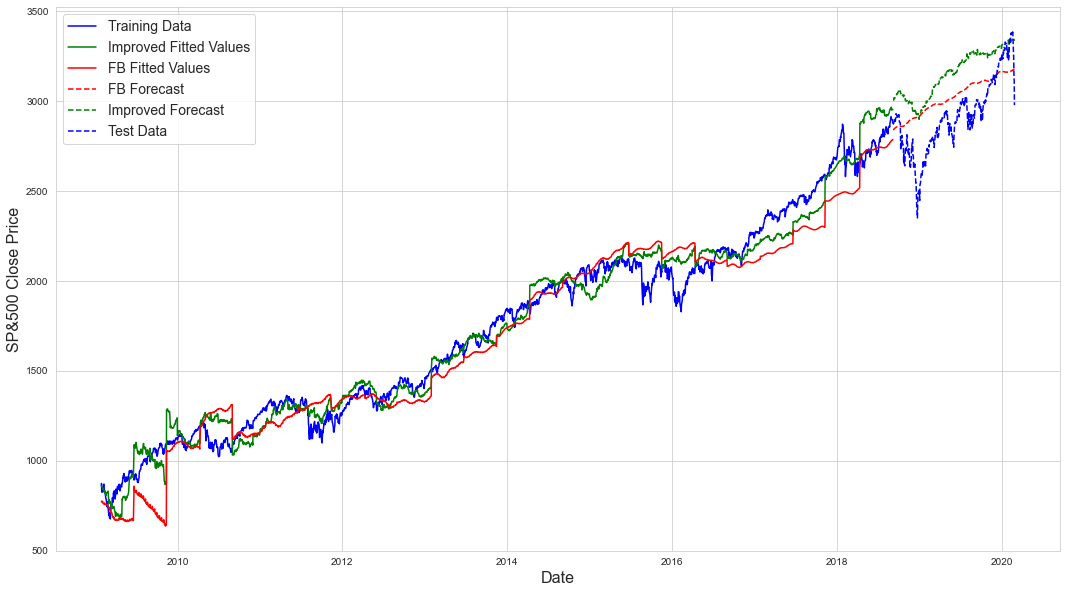

In [19]:
plt.figure(figsize=(18,10))

# plot the training data
plt.plot(df_train.ds,df_train.y,'b',
            label = "Training Data")

plt.plot(df_train.ds, pp_train,'g-',
            label = "Improved Fitted Values")

# plot the fit
plt.plot(df_train.ds, df_train.fbsp,'r-',
            label = "FB Fitted Values")

# # plot the forecast
plt.plot(df_test.ds, df_test.fbsp,'r--',
            label = "FB Forecast")
plt.plot(df_test.ds, pp_test,'g--',
            label = "Improved Forecast")
plt.plot(df_test.ds,df_test.y,'b--',
            label = "Test Data")

plt.legend(fontsize=14)

plt.xlabel("Date", fontsize=16)
plt.ylabel("SP&500 Close Price", fontsize=16)

plt.show()